<a href="https://colab.research.google.com/github/leighTOR/fishlens-model/blob/main/vgg16/fishlens_vgg16v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import numpy as np
import seaborn as sns
import csv
import time
import pandas as pd

In [5]:
# Define the dataset class for image classification
class FishDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with subdirectories for each class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Ensure consistent class ordering
        self.class_to_idx = {cls_name: int(cls_name) for cls_name in self.classes}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Define image transformations
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
# Setup directories (update these paths to your dataset)
train_dir = '/content/drive/MyDrive/datasets/train'
val_dir = '/content/drive/MyDrive/datasets/val'

# Create datasets and dataloaders
train_dataset = FishDiseaseDataset(train_dir, transform=train_transforms)
val_dataset = FishDiseaseDataset(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Get number of classes
num_classes = len(train_dataset.classes)
print(f'Number of classes: {num_classes}')
print(f'Classes: {train_dataset.classes}')

Number of classes: 12
Classes: ['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Load and modify VGG-16 model
from torchvision import models

model = models.vgg16(pretrained=True)

# Freeze convolutional layers if you want to use the model as a feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]


In [9]:
# Training loop
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels



In [11]:
def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels

In [14]:
# Function to calculate precision, recall, F1, and mAP
def calculate_metrics(all_labels, all_preds):
    # Reshape labels and predictions to 2D arrays
    all_labels = np.array(all_labels).reshape(-1, 1) # Reshape to 2D
    all_preds = np.array(all_preds).reshape(-1, 1) # Reshape to 2D

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    # mAP is not typically used for classification; it's more common in detection tasks.
    mAP = average_precision_score(all_labels, all_preds, average='macro')
    return precision, recall, f1, mAP

In [16]:
# Main training loop with time indicator and metrics storage
num_epochs = 20
save_dir = "/content/metrics"
os.makedirs(save_dir, exist_ok=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s, mAPs = [], [], [], []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_accuracy, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_preds, val_labels = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    precision, recall, f1, mAP = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    mAPs.append(mAP)

    epoch_time = time.time() - start_time

    print("=========================================================")
    print(f'Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, mAP: {mAP:.4f}')

# Save the model's state dictionary with a clear name in the save directory
torch.save(model.state_dict(), f'{save_dir}/vgg16_fish_disease_model.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 | Time: 21.71s
Train Loss: 0.4779, Train Accuracy: 86.82%
Val Loss: 3.5712, Val Accuracy: 45.45%
Precision: 0.3715, Recall: 0.4545, F1 Score: 0.3815, mAP: 0.2643


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20 | Time: 17.92s
Train Loss: 0.5501, Train Accuracy: 84.55%
Val Loss: 2.8637, Val Accuracy: 56.36%
Precision: 0.5904, Recall: 0.5636, F1 Score: 0.5278, mAP: 0.0768


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20 | Time: 16.97s
Train Loss: 0.6370, Train Accuracy: 83.64%
Val Loss: 3.4811, Val Accuracy: 50.91%
Precision: 0.4768, Recall: 0.5091, F1 Score: 0.4770, mAP: 0.0933


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/20 | Time: 15.06s
Train Loss: 1.0362, Train Accuracy: 84.55%
Val Loss: 3.6196, Val Accuracy: 40.00%
Precision: 0.3937, Recall: 0.4000, F1 Score: 0.3769, mAP: 0.1201


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20 | Time: 15.02s
Train Loss: 0.6835, Train Accuracy: 86.36%
Val Loss: 3.5292, Val Accuracy: 50.91%
Precision: 0.4341, Recall: 0.5091, F1 Score: 0.4495, mAP: 0.1486


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20 | Time: 10.98s
Train Loss: 0.8559, Train Accuracy: 87.73%
Val Loss: 3.4076, Val Accuracy: 50.91%
Precision: 0.4094, Recall: 0.5091, F1 Score: 0.4460, mAP: 0.0783


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20 | Time: 13.94s
Train Loss: 0.9055, Train Accuracy: 86.36%
Val Loss: 4.2022, Val Accuracy: 47.27%
Precision: 0.4850, Recall: 0.4727, F1 Score: 0.4361, mAP: 0.0842


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/20 | Time: 14.33s
Train Loss: 1.0254, Train Accuracy: 87.73%
Val Loss: 3.6915, Val Accuracy: 49.09%
Precision: 0.4499, Recall: 0.4909, F1 Score: 0.4293, mAP: 0.0807


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20 | Time: 12.23s
Train Loss: 0.5566, Train Accuracy: 89.09%
Val Loss: 4.2658, Val Accuracy: 47.27%
Precision: 0.4653, Recall: 0.4727, F1 Score: 0.4330, mAP: 0.1415


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20 | Time: 14.53s
Train Loss: 0.6763, Train Accuracy: 89.09%
Val Loss: 4.5023, Val Accuracy: 47.27%
Precision: 0.4443, Recall: 0.4727, F1 Score: 0.4258, mAP: 0.1685


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20 | Time: 12.58s
Train Loss: 0.3933, Train Accuracy: 91.36%
Val Loss: 4.2237, Val Accuracy: 50.91%
Precision: 0.4247, Recall: 0.5091, F1 Score: 0.4424, mAP: 0.1836


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20 | Time: 13.47s
Train Loss: 0.3243, Train Accuracy: 93.64%
Val Loss: 4.9464, Val Accuracy: 49.09%
Precision: 0.3877, Recall: 0.4909, F1 Score: 0.4157, mAP: 0.1080


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20 | Time: 18.18s
Train Loss: 1.1641, Train Accuracy: 90.00%
Val Loss: 4.9030, Val Accuracy: 56.36%
Precision: 0.5130, Recall: 0.5636, F1 Score: 0.4897, mAP: 0.2647


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/20 | Time: 17.17s
Train Loss: 0.3635, Train Accuracy: 93.64%
Val Loss: 4.1976, Val Accuracy: 54.55%
Precision: 0.5671, Recall: 0.5455, F1 Score: 0.5329, mAP: 0.0659


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/20 | Time: 16.65s
Train Loss: 0.3401, Train Accuracy: 95.91%
Val Loss: 7.3649, Val Accuracy: 41.82%
Precision: 0.4602, Recall: 0.4182, F1 Score: 0.3717, mAP: 0.1158


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/20 | Time: 16.81s
Train Loss: 0.4928, Train Accuracy: 94.09%
Val Loss: 5.7054, Val Accuracy: 52.73%
Precision: 0.5662, Recall: 0.5273, F1 Score: 0.5179, mAP: 0.0706


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/20 | Time: 16.47s
Train Loss: 1.3581, Train Accuracy: 88.64%
Val Loss: 7.0953, Val Accuracy: 56.36%
Precision: 0.6089, Recall: 0.5636, F1 Score: 0.5267, mAP: 0.0870


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/20 | Time: 17.69s
Train Loss: 1.0178, Train Accuracy: 91.36%
Val Loss: 6.9823, Val Accuracy: 45.45%
Precision: 0.4502, Recall: 0.4545, F1 Score: 0.4099, mAP: 0.0903


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/20 | Time: 16.42s
Train Loss: 0.8073, Train Accuracy: 92.27%
Val Loss: 7.5484, Val Accuracy: 56.36%
Precision: 0.6196, Recall: 0.5636, F1 Score: 0.5302, mAP: 0.0768


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/20 | Time: 14.42s
Train Loss: 0.9902, Train Accuracy: 91.82%
Val Loss: 6.3389, Val Accuracy: 45.45%
Precision: 0.4338, Recall: 0.4545, F1 Score: 0.4179, mAP: 0.0796


In [17]:
# Save results to CSV
with open(f'{save_dir}/metrics_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_epochs):
        writer.writerow({
            'Epoch': i + 1,
            'Train Loss': train_losses[i],
            'Val Loss': val_losses[i],
            'Train Accuracy': train_accuracies[i],
            'Val Accuracy': val_accuracies[i],
            'Precision': precisions[i],
            'Recall': recalls[i],
            'F1 Score': f1s[i],
            'mAP': mAPs[i]
        })

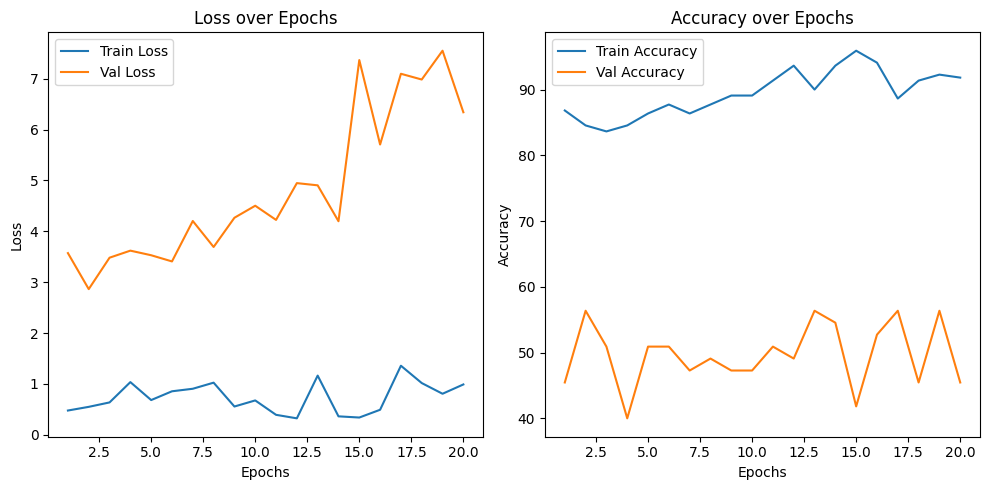

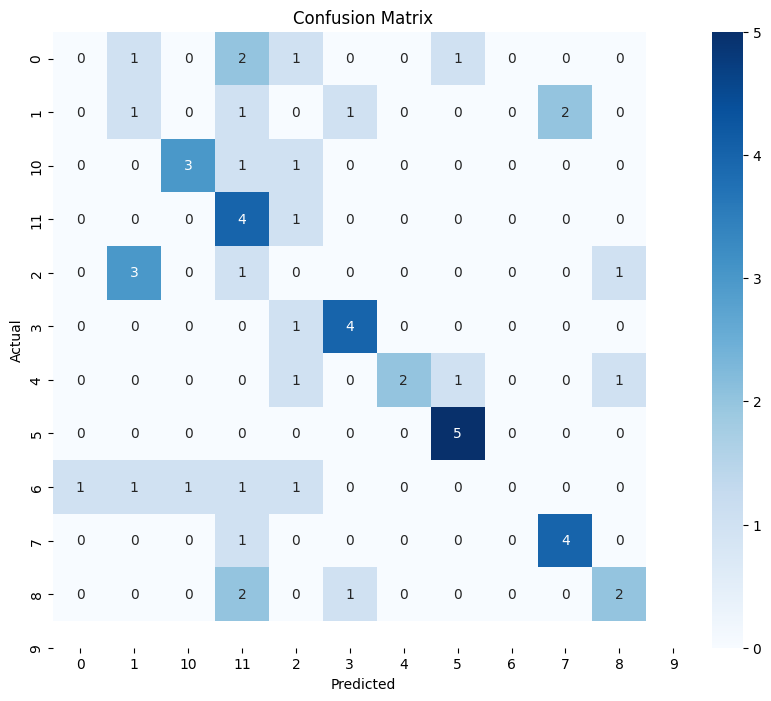

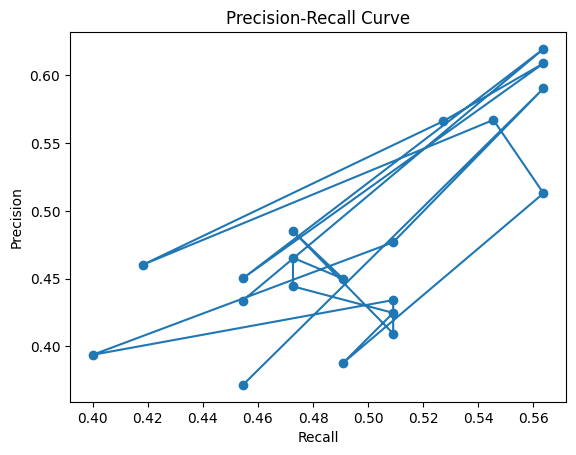

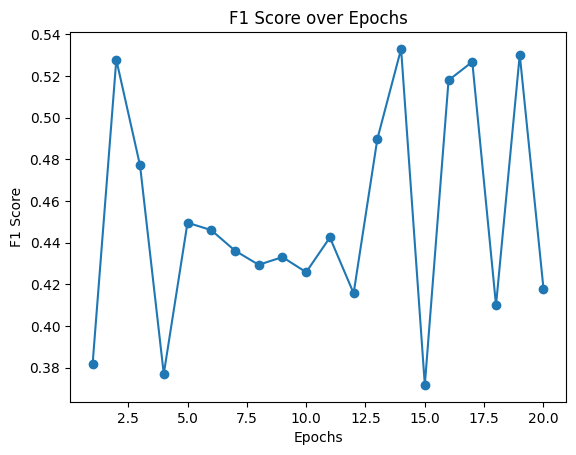

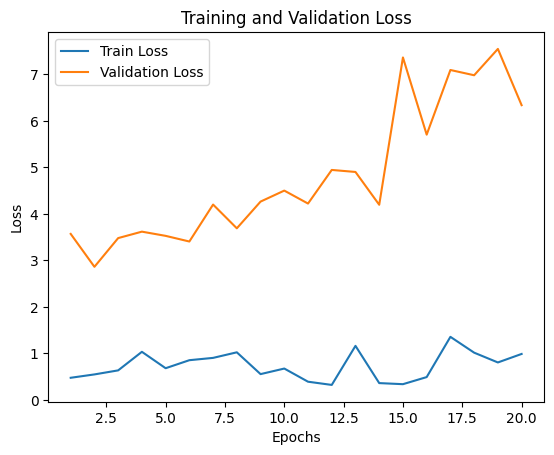

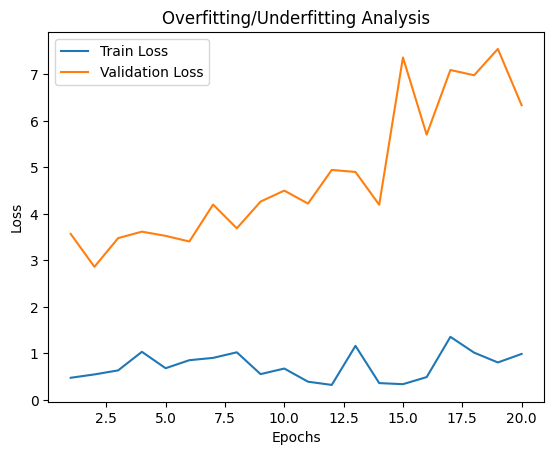

Metrics and plots are saved in /content/metrics


In [18]:
# Final graph plotting after the last epoch
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/loss_accuracy_plot.png")
    plt.show()

# Display confusion matrix
def plot_confusion_matrix(val_labels, val_preds, class_names):
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig(f"{save_dir}/confusion_matrix.png")
    plt.show()

# Additional graph plotting functions

# 1. Precision-Recall Curve
def plot_precision_recall_curve(recalls, precisions):
    plt.figure()
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig(f"{save_dir}/precision_recall_curve.png")
    plt.show()

# 2. F1-Score Curve
def plot_f1_score_curve(f1s):
    plt.figure()
    plt.plot(range(1, len(f1s)+1), f1s, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.savefig(f"{save_dir}/f1_score_curve.png")
    plt.show()

# 3. Loss Curves (Training and Validation)
def plot_loss_curves(train_losses, val_losses):
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"{save_dir}/loss_curves.png")
    plt.show()

# 4. Overfitting/Underfitting Analysis (Training vs Validation Loss)
def plot_overfitting_analysis(train_losses, val_losses):
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Overfitting/Underfitting Analysis')
    plt.legend()
    plt.savefig(f"{save_dir}/overfitting_analysis_loss.png")
    plt.show()

# Plot and save the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(val_labels, val_preds, train_dataset.classes)
plot_precision_recall_curve(recalls, precisions)
plot_f1_score_curve(f1s)
plot_loss_curves(train_losses, val_losses)
plot_overfitting_analysis(train_losses, val_losses)

# Also save the metrics to a text file
with open(f'{save_dir}/evaluation_metrics.txt', 'w') as f:
    f.write(f'Precision: {precisions[-1]}\n')
    f.write(f'Recall: {recalls[-1]}\n')
    f.write(f'F1 Score: {f1s[-1]}\n')
    f.write(f'mAP: {mAPs[-1]}\n')

print(f"Metrics and plots are saved in {save_dir}")

# Load the metrics_results.csv file
results_df = pd.read_csv(f'{save_dir}/metrics_results.csv')

<ipython-input-19-24ff8ecf1290>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df[col].fillna(median_value, inplace=True)


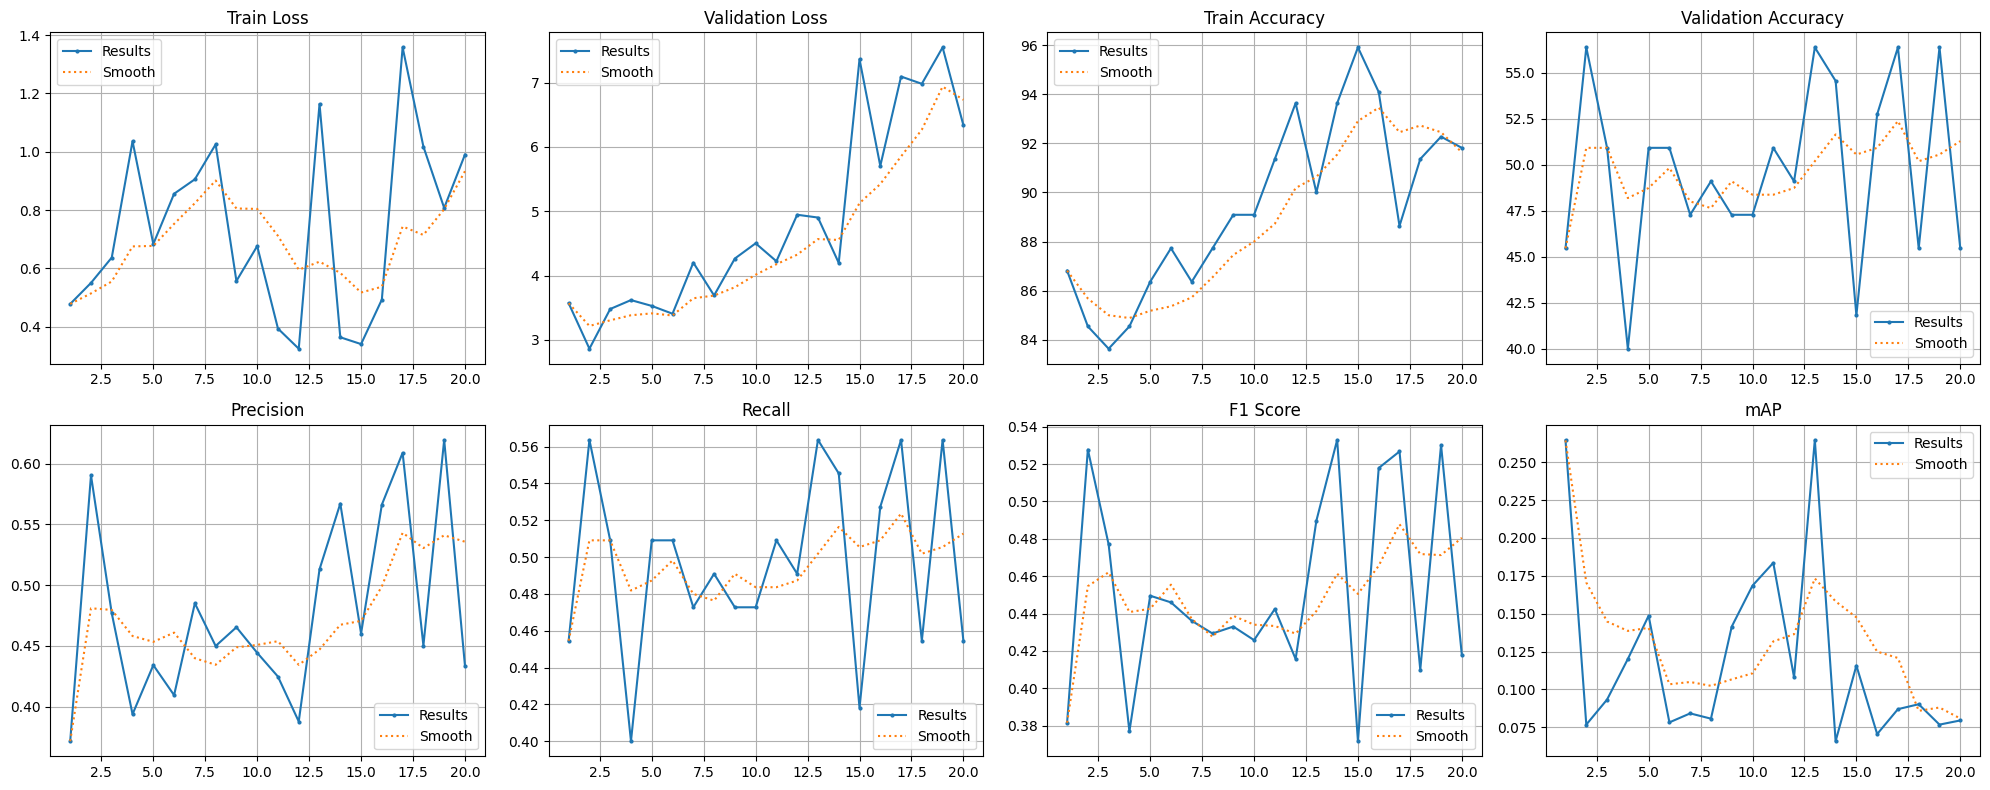

In [19]:
# Ensure numeric columns
numeric_cols = ['Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP']
for col in numeric_cols:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

# Replace inf and NaN values with the median of each column
for col in numeric_cols:
    median_value = results_df[col].median()
    results_df[col] = results_df[col].replace([np.inf, -np.inf], np.nan)
    results_df[col].fillna(median_value, inplace=True)

# Define a smoothing function using a rolling window
def smooth(data, window_size=5):
    return data.rolling(window=window_size, min_periods=1).mean()

# Apply smoothing to some metrics
smoothed_train_loss = smooth(results_df['Train Loss'])
smoothed_val_loss = smooth(results_df['Val Loss'])
smoothed_train_acc = smooth(results_df['Train Accuracy'])
smoothed_val_acc = smooth(results_df['Val Accuracy'])
smoothed_precision = smooth(results_df['Precision'])
smoothed_recall = smooth(results_df['Recall'])
smoothed_f1 = smooth(results_df['F1 Score'])
smoothed_map = smooth(results_df['mAP'])

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

epochs = results_df['Epoch']

# First row: Training losses and accuracies
axs[0, 0].plot(epochs, results_df['Train Loss'], label='Results', marker='o', markersize=2)
axs[0, 0].plot(epochs, smoothed_train_loss, label='Smooth', linestyle='dotted')
axs[0, 0].set_title('Train Loss')

axs[0, 1].plot(epochs, results_df['Val Loss'], label='Results', marker='o', markersize=2)
axs[0, 1].plot(epochs, smoothed_val_loss, label='Smooth', linestyle='dotted')
axs[0, 1].set_title('Validation Loss')

axs[0, 2].plot(epochs, results_df['Train Accuracy'], label='Results', marker='o', markersize=2)
axs[0, 2].plot(epochs, smoothed_train_acc, label='Smooth', linestyle='dotted')
axs[0, 2].set_title('Train Accuracy')

axs[0, 3].plot(epochs, results_df['Val Accuracy'], label='Results', marker='o', markersize=2)
axs[0, 3].plot(epochs, smoothed_val_acc, label='Smooth', linestyle='dotted')
axs[0, 3].set_title('Validation Accuracy')

# Second row: Precision, Recall, F1 Score, mAP
axs[1, 0].plot(epochs, results_df['Precision'], label='Results', marker='o', markersize=2)
axs[1, 0].plot(epochs, smoothed_precision, label='Smooth', linestyle='dotted')
axs[1, 0].set_title('Precision')

axs[1, 1].plot(epochs, results_df['Recall'], label='Results', marker='o', markersize=2)
axs[1, 1].plot(epochs, smoothed_recall, label='Smooth', linestyle='dotted')
axs[1, 1].set_title('Recall')

axs[1, 2].plot(epochs, results_df['F1 Score'], label='Results', marker='o', markersize=2)
axs[1, 2].plot(epochs, smoothed_f1, label='Smooth', linestyle='dotted')
axs[1, 2].set_title('F1 Score')

axs[1, 3].plot(epochs, results_df['mAP'], label='Results', marker='o', markersize=2)
axs[1, 3].plot(epochs, smoothed_map, label='Smooth', linestyle='dotted')
axs[1, 3].set_title('mAP')

# Add legends and grid
for ax in axs.flat:
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig(f'{save_dir}/results_smoothed.png')

# Show the plot
plt.show()